In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import backtrader as bt
import empyrical
import datetime
import pandas as pd
from backtrader.utils.py3 import iteritems
import pdb
import pyfolio as pf
import decimal

import matplotlib
%matplotlib inline

/Users/gabrielfior/miniconda3/envs/pyfolio35/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
def get_data_feed_by_name(data_feed_name, start, end):
    return bt.feeds.YahooFinanceData(dataname=data_feed_name,period='d', fromdate=start,
                                todate=end)

def get_local_data_feed_by_name(data_filename,start,end):
    return bt.feeds.YahooFinanceCSVData(
        dataname=data_filename,
        # Do not pass values before this date
        fromdate=start,
        # Do not pass values after this date
        todate=end,
        reverse=False)

In [7]:
# ToDo - Complete later

class PortfolioAllocation:
    def __init__(self, allocation={}):
        self.allocation = allocation
        self.equities = list(self.allocation.keys())

In [11]:
start=datetime.datetime(2020,1,1)
end=datetime.datetime(2020,3,20)
# relevant ETFs
# emerging markets -> IS3N.DE
# europe -> EXSA.DE
# USA -> NASDAQ 100 
# china -> ICGA.DE
# pacific -> VGEK.DE
# bonds -> AGGH.SW
# japan -> EUNN.DE
# tech -> IJPA.AS
data_vusa = get_data_feed_by_name('VUSA.DE',start,end)
data_stoxx = get_data_feed_by_name('EXSA.DE',start,end)
data_emerging_markets = get_data_feed_by_name('IS3N.DE',start,end)
data_nasdaq100 = get_data_feed_by_name('SXRV.DE',start,end)
data_china = get_data_feed_by_name('ICGA.DE',start,end)
data_pacific = get_data_feed_by_name('VGEK.DE',start,end)
data_bonds = get_data_feed_by_name('AGGH.MI',start,end)
data_japan = get_data_feed_by_name('EUNN.DE',start,end)
data_tech = get_data_feed_by_name('IJPA.AS',start,end)

In [32]:
data_vusa_csv = get_local_data_feed_by_name('VUSA.DE.csv',start,end)
data_stoxx_csv = get_local_data_feed_by_name('EXSA.DE.csv',start,end)
# data_tech_csv = get_local_data_feed_by_name('IJPA.AS.csv',start,end)
# data_japan_csv = get_local_data_feed_by_name('EUNN.DE.csv',start,end)
# data_bonds_csv = get_local_data_feed_by_name('AGGH.MI.csv',start,end)
# #data_pacific_csv = get_local_data_feed_by_name('VGEK.DE.csv',start,end)
# data_pacific_csv = get_local_data_feed_by_name('VGEK.DE2.csv',start,end)
# data_china_csv = get_local_data_feed_by_name('ICGA.DE.csv',start,end)
# data_nasdaq100_csv = get_local_data_feed_by_name('SXRV.DE.csv',start,end)

In [33]:
etf_allocation = {'vusa':(data_vusa,0.5),
                  'stoxx':(data_stoxx,0.5),
                  #'emerging_markets':(data_emerging_markets,0.333),
                 #'nasdaq100':(data_nasdaq100,0.333),
            #'china':(data_china,0.05),
                 #'pacific':(data_pacific,0.05),'bonds':(data_bonds,0.1),
                 #'japan':(data_japan,0.03), 'tech':(data_tech,0.02)
                }

etf_allocation_csv = {'vusa':(data_vusa_csv,0.5),
                      'stoxx':(data_stoxx_csv,0.5)
                 #'nasdaq100':(data_nasdaq100_csv,0.25),'china':(data_china_csv,0.05),
                 #'pacific':(data_pacific_csv,0.05),
                      #'pacific':(data_pacific,0.05),
                 #     'bonds':(data_bonds_csv,0.05),
                 #'japan':(data_japan_csv,0.05), 'tech':(data_tech_csv,0.05)
                     }
                 
print (sum([v[1] for k,v in etf_allocation.items()]))

1.0


In [14]:
#bt.Strategy.getdatabyname
bt.Strategy.order_target_value()

<function backtrader.strategy.Strategy.getdatabyname(self, name)>

In [77]:
class BuyAndHold_More_Fund(bt.Strategy):
    # ToDo - Add etf allocation to init method
    params = dict(
        monthly_cash=700.0,  # amount of cash to buy every month
    )

    def start(self):
        # Activate the fund mode and set the default value at 100
        self.broker.set_fundmode(fundmode=True, fundstartval=100.00)
        self.cash_start = self.broker.get_cash()
        self.val_start = 100.0

        # Add a timer which will be called on the 1st trading day of the month
        self.add_timer(
            bt.timer.SESSION_END,  # when it will be called
            monthdays=[1],  # called on the 1st day of the month
            monthcarry=True,  # called on the 2nd day if the 1st is holiday
        )

    def buy_fixed_cash_amount(self, target_value, data_name):
        data_feed = self.getdatabyname(name=data_name)
        size = round(target_value/data_feed.close,2)
        print ('buying size {} of data {}, target_value {}'.format(size,data_name,target_value))
        return self.buy(exectype=bt.Order.Market,size=size,data=data_feed)
        
    def notify_timer(self, timer, when, *args, **kwargs):
        # Add the influx of monthly cash to the broker
        self.broker.add_cash(self.p.monthly_cash)

        # buy available cash
        target_value = self.broker.getcash() + self.p.monthly_cash
        #self.buy_fixed_cash_amount(target_value,'vusa')
        
        # follow asset allocation
        order_list = []
        for data_name,(data_feed,percent_allocation) in etf_allocation_csv.items():
            target = target_value*percent_allocation
            print ('buying {} from {} when {}, total target {}'.format(target, data_name, when, target_value))
            order = self.buy_fixed_cash_amount(target,data_name)
            if not order:
                print ('could not buy from {} when {}'.format(data_name, when))
        
        
        #self.order_target_value(target=target_value/2, data='vusa')
        #self.order_target_value(target=target_value/2, data='stoxx')

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1.0
        self.froi = self.broker.get_fundvalue() - self.val_start
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value: {:.2f}%'.format(self.froi))
        print ('broker fund value {} broker val start {}'.format(self.broker.get_fundvalue(),self.val_start))

In [78]:
    for data_name,(data_feed,percent_allocation) in etf_allocation_csv.items():
        print (data_name, data_feed, percent_allocation)

vusa <backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7f8109b2aac8> 0.5
stoxx <backtrader.feeds.yahoo.YahooFinanceCSVData object at 0x7f8109b2db00> 0.5


In [79]:
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(BuyAndHold_More_Fund)
    cerebro.broker.set_cash(0.000001)
    cerebro.broker.set_fundmode(True)
    
    
    #for data_name,(data_feed,percent_allocation) in etf_allocation.items():    
    #    cerebro.adddata(data_feed, name=data_name)
    for data_name,(data_feed,percent_allocation) in etf_allocation_csv.items():
        cerebro.adddata(data_feed, name=data_name)
        
        
    #cerebro.adddata(data_vusa_csv, name='vusa')
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Observers
    cerebro.addobserver(bt.observers.TimeReturn, timeframe=bt.TimeFrame.Days)
    
    # Analyzers
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio', timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.PositionsValue, headers=True, cash=True, _name='mypositions')
    cerebro.addanalyzer(bt.analyzers.TimeReturn,_name='timereturn')

    results = cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 0.00
buying 350.0000005 from vusa when 2020-01-02 23:59:59.999990, total target 700.000001
buying size 6.37 of data vusa, target_value 350.0000005
buying 350.0000005 from stoxx when 2020-01-02 23:59:59.999990, total target 700.000001
buying size 8.46 of data stoxx, target_value 350.0000005
buying 351.25865049999993 from vusa when 2020-02-03 23:59:59.999990, total target 702.5173009999999
buying size 6.29 of data vusa, target_value 351.25865049999993
buying 351.25865049999993 from stoxx when 2020-02-03 23:59:59.999990, total target 702.5173009999999
buying size 8.68 of data stoxx, target_value 351.25865049999993
buying 524.3209505 from vusa when 2020-03-02 23:59:59.999990, total target 1048.641901
buying size 10.39 of data vusa, target_value 524.3209505
buying 524.3209505 from stoxx when 2020-03-02 23:59:59.999990, total target 1048.641901
buying size 14.14 of data stoxx, target_value 524.3209505
ROI:        172976610000.00%
Fund Value: -19.64%
broker fund valu

In [80]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio',)
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items() #<--positions only holds data for one symbol here

p = strat.analyzers.getbyname('mypositions').get_analysis()
mypositions = [[k] + v for k, v in iteritems(p)] #<-- Now positions will hold data for all symbols
cols = mypositions.pop(0)  # headers are in the first entry
mypositions = pd.DataFrame.from_records(mypositions, index=cols[0], columns=cols)
mypositions.index = pd.DatetimeIndex(mypositions.index) 

In [81]:
positions.tail()

,stoxx,cash
Datetime,,
2020-03-13 00:00:00+00:00,251.1774,503.998101
2020-03-16 00:00:00+00:00,238.9950,503.998101
2020-03-17 00:00:00+00:00,243.0558,503.998101
2020-03-18 00:00:00+00:00,232.2270,503.998101
2020-03-19 00:00:00+00:00,241.5330,503.998101


In [83]:
transactions.head(10)

,amount,price,sid,symbol,value
date,,,,,
2020-01-03 23:59:59.999989+00:00,6.37,54.91,0,vusa,-349.7767
2020-01-03 23:59:59.999989+00:00,8.46,41.10,1,stoxx,-347.7060
2020-02-04 23:59:59.999989+00:00,6.29,56.26,0,vusa,-353.8754
2020-03-03 23:59:59.999989+00:00,10.39,52.42,0,vusa,-544.6438


In [69]:
mypositions['total'] = mypositions.sum(axis=1)
myreturns = mypositions['total'].pct_change()
myreturns.index = pd.to_datetime(myreturns.index).tz_localize('US/Eastern')

In [50]:
mypositions.head()

,vusa,stoxx,cash,total
Datetime,,,,
2020-01-02,0.00,0.0,700.000001,700.000001
2020-01-03,659.88,0.0,41.080001,700.960001
2020-01-06,658.44,0.0,41.080001,699.520001
2020-01-07,662.88,0.0,41.080001,703.960001
2020-01-08,666.12,0.0,41.080001,707.200001


In [64]:
strat = results[0]
timereturn_analyzer = strat.analyzers.getbyname('timereturn')
timereturn = timereturn_analyzer.get_analysis()

In [65]:
timereturn_df = pd.DataFrame([(k,v) for k,v in timereturn.items()],columns=['date','return'])
timereturn_df.set_index('date',inplace=True)

In [66]:
timereturn_df.head()

,return
date,
2017-10-26,0.000000
2017-10-27,0.005590
2017-10-30,-0.005082
2017-10-31,0.000000
2017-11-01,0.003193


Stress Events,mean,min,max
New Normal,0.04%,-7.90%,8.43%


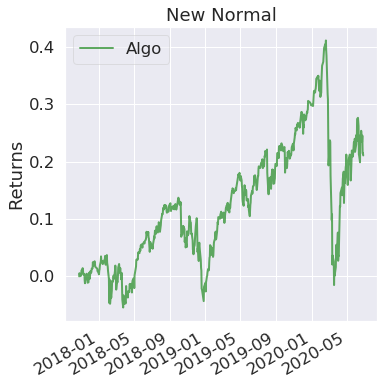

In [67]:
pf.create_interesting_times_tear_sheet(timereturn_df['return'])

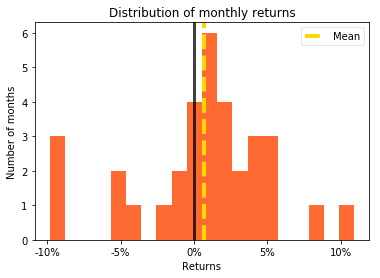

In [68]:
pf.plot_monthly_returns_dist(timereturn_df['return'])

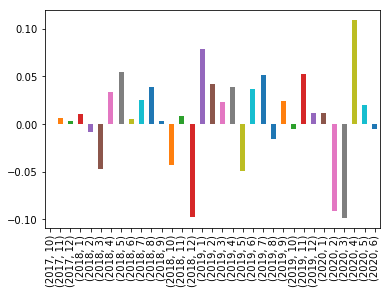

In [69]:
empyrical.aggregate_returns(timereturn_df['return'],'monthly').plot(kind='bar')

Start date,2017-10-26
End date,2020-06-26
Total months,31
,Backtest
Annual return,7.5%
Cumulative returns,21.1%
Annual volatility,19.3%
Sharpe ratio,0.47
Calmar ratio,0.25
Stability,0.67
Max drawdown,-30.2%


/Users/gabrielfior/miniconda3/envs/pyfolio35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:1033: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return argmin(axis, out)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.23,2020-02-19,2020-03-18,NaT,NaN
1,15.86,2018-10-01,2018-12-27,2019-04-01,131
2,8.82,2018-01-29,2018-03-26,2018-05-16,78
3,6.41,2019-04-29,2019-06-03,2019-07-03,48
4,6.38,2019-08-01,2019-08-06,2019-09-11,30


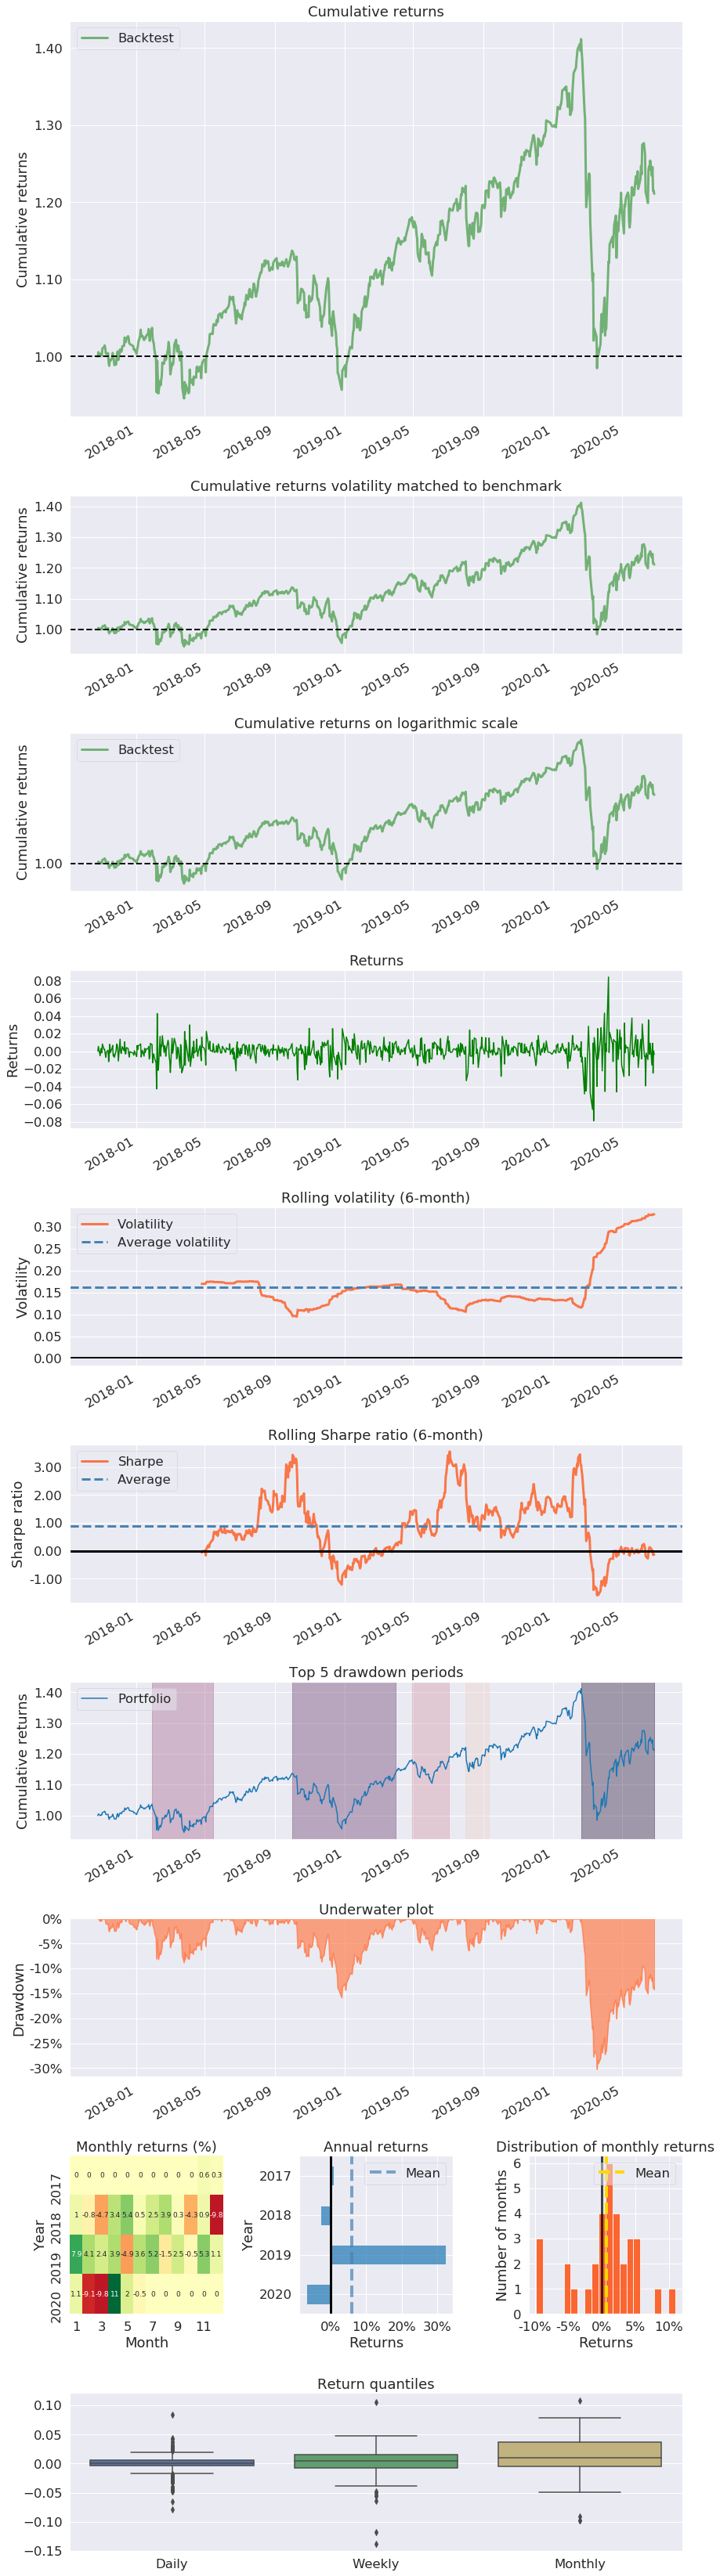

In [72]:
figs=pf.create_returns_tear_sheet(timereturn_df['return'],return_fig=True)

# Explore data object

1. Check how we can get ranges from data, and maybe display a warning telling that portfolio cannot be simulated that far.